In [22]:
import numpy as np

def compute_distance_transform(image):
    # Placeholder for distance transform computation
    # This should compute the distance to the nearest edge for each pixel
    distance = np.zeros_like(image, dtype=float)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] == 0:
                # For background pixels, distance is zero
                distance[i, j] = 0
            else:
                # For object pixels, find the minimum distance to a background pixel
                min_dist = float('inf')
                for ii in range(image.shape[0]):
                    for jj in range(image.shape[1]):
                        if image[ii, jj] == 0:
                            dist = np.sqrt((i - ii)**2 + (j - jj)**2)
                            if dist < min_dist:
                                min_dist = dist
                distance[i, j] = min_dist
    return distance


def find_local_minima(distance):
    # Placeholder for finding local minima in the distance transform
    # This should return a list of pixel coordinates that are local minima
    local_minima = []
    for i in range(1, distance.shape[0] - 1):
        for j in range(1, distance.shape[1] - 1):
            neighborhood = distance[i-1:i+2, j-1:j+2]
            if distance[i, j] <= np.min(neighborhood):
                local_minima.append((i, j))
    return local_minima

    pass

def watershed(image):
    # Step 1: Convert to grayscale and threshold
    # Assuming 'image' is already a binary image after thresholding

    # Step 2: Compute distance transform
    distance = compute_distance_transform(image)

    # Step 3: Find local minima
    local_minima = find_local_minima(distance)

    # Step 4: Initialize labels
    labels = np.zeros_like(image, dtype=int)
    label = 1
    for minima in local_minima:
        labels[minima] = label
        label += 1

    # Step 5: Simulate flooding
    # Sort pixels by distance transform value in descending order
    sorted_pixels = [(distance[i, j], i, j) for i in range(image.shape[0]) for j in range(image.shape[1])]
    sorted_pixels.sort(reverse=True)

    for _, i, j in sorted_pixels:
        if labels[i, j] == 0:
            # Assign label based on the labeled neighbor
            labels[i, j] = find_label_from_neighbors(labels, i, j)

    # Step 6: Merge and segment
    # This step involves refining the labels to create distinct boundaries

    return labels

def find_label_from_neighbors(labels, i, j):
    # Placeholder for determining the label of a pixel based on its neighbors
    # This should return the most appropriate label based on the surrounding pixels
    neighbors = [
        labels[x, y]
        for x in range(max(0, i-1), min(labels.shape[0], i+2))
        for y in range(max(0, j-1), min(labels.shape[1], j+2))
        if labels[x, y] > 0
    ]
    if neighbors:
        return max(neighbors, key=neighbors.count)
    return 0



In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread("../Attachment/Attachment 1/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
print(img.shape)
label = watershed(img)

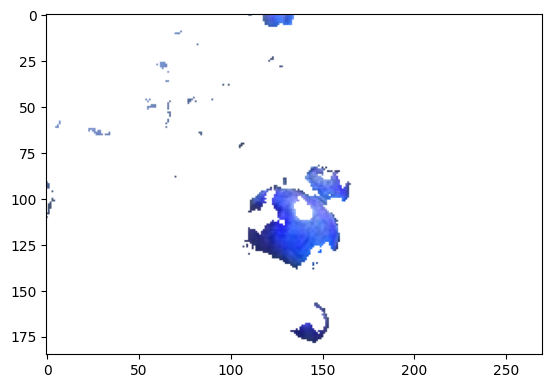

In [25]:
import cv2
import numpy as np

# Load the image
image = cv2.imread("../Attachment/Attachment 1/1.jpg")

# Convert to HSV (Hue, Saturation, Value) color space for easier color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define range of apple color in HSV
# Note: These values depend on the color of the apples and lighting conditions
lower_red = np.array([0, 100, 100])
upper_red = np.array([10, 255, 255])

# Threshold the HSV image to get only apple colors
mask = cv2.inRange(hsv_image, lower_red, upper_red)

# Bitwise-AND mask and original image
apple_segment = cv2.bitwise_and(image, image, mask=mask)

# Convert non-apple parts to white
white_background = np.ones_like(image, np.uint8) * 255
apple_white_bg = np.where(apple_segment == 0, white_background, apple_segment)

# Save or display the image
'''cv2.imwrite('apples_on_white_background.png', apple_white_bg)
cv2.imshow('Apples', apple_white_bg)'''
plt.imshow(apple_white_bg)


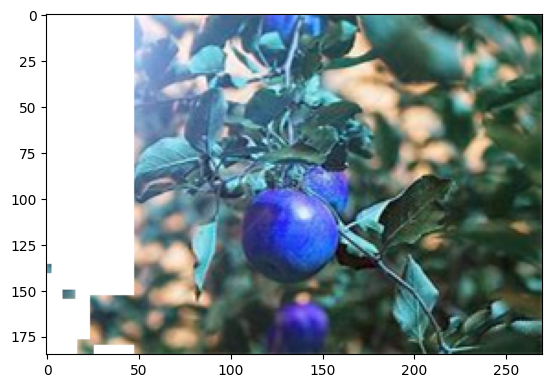

In [27]:
import cv2
import numpy as np

def segment_color(image, lower, upper):
    mask = cv2.inRange(image, lower, upper)
    return mask

def extract_apples(image_path):
    # Load the image
    image = cv2.imread(image_path)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color ranges for red, green, and yellow apples
    # Note: These ranges might need adjustment
    lower_red = np.array([0, 120, 70])
    upper_red = np.array([10, 255, 255])
    lower_green = np.array([25, 52, 72])
    upper_green = np.array([102, 255, 255])
    lower_yellow = np.array([22, 93, 0])
    upper_yellow = np.array([45, 255, 255])

    # Segment apples based on color
    red_apples = segment_color(hsv_image, lower_red, upper_red)
    green_apples = segment_color(hsv_image, lower_green, upper_green)
    yellow_apples = segment_color(hsv_image, lower_yellow, upper_yellow)

    # Combine masks
    combined_mask = cv2.bitwise_or(red_apples, green_apples)
    combined_mask = cv2.bitwise_or(combined_mask, yellow_apples)

    # Morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
    combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

    # Detect contours
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Create an output image with a white background
    output_image = np.ones_like(image) * 255

    # Draw the apples on the output image
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        output_image[y:y+h, x:x+w] = image[y:y+h, x:x+w]

    return output_image

# Example usage
output = extract_apples("../Attachment/Attachment 1/1.jpg")
plt.imshow(output)


In [ ]:
import numpy as np
from collections import deque

# Implementation of:
# Pierre Soille, Luc M. Vincent, "Determining watersheds in digital pictures via
# flooding simulations", Proc. SPIE 1360, Visual Communications and Image Processing
# '90: Fifth in a Series, (1 September 1990); doi: 10.1117/12.24211;
# http://dx.doi.org/10.1117/12.24211
class Watershed(object):
   MASK = -2
   WSHD = 0
   INIT = -1
   INQE = -3

   def __init__(self, levels = 256):
      self.levels = levels

   # Neighbour (coordinates of) pixels, including the given pixel.
   def _get_neighbors(self, height, width, pixel):
      return np.mgrid[
         max(0, pixel[0] - 1):min(height, pixel[0] + 2),
         max(0, pixel[1] - 1):min(width, pixel[1] + 2)
      ].reshape(2, -1).T

   def apply(self, image):
      current_label = 0
      flag = False
      fifo = deque()

      height, width = image.shape
      total = height * width
      labels = np.full((height, width), self.INIT, np.int32)

      reshaped_image = image.reshape(total)
      # [y, x] pairs of pixel coordinates of the flattened image.
      pixels = np.mgrid[0:height, 0:width].reshape(2, -1).T
      # Coordinates of neighbour pixels for each pixel.
      neighbours = np.array([self._get_neighbors(height, width, p) for p in pixels])
      if len(neighbours.shape) == 3:
         # Case where all pixels have the same number of neighbours.
         neighbours = neighbours.reshape(height, width, -1, 2)
      else:
         # Case where pixels may have a different number of pixels.
         neighbours = neighbours.reshape(height, width)

      indices = np.argsort(reshaped_image)
      sorted_image = reshaped_image[indices]
      sorted_pixels = pixels[indices]

      # self.levels evenly spaced steps from minimum to maximum.
      levels = np.linspace(sorted_image[0], sorted_image[-1], self.levels)
      level_indices = []
      current_level = 0

      # Get the indices that deleimit pixels with different values.
      for i in range(total):
         if sorted_image[i] > levels[current_level]:
            # Skip levels until the next highest one is reached.
            while sorted_image[i] > levels[current_level]: current_level += 1
            level_indices.append(i)
      level_indices.append(total)

      start_index = 0
      for stop_index in level_indices:
         # Mask all pixels at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            labels[p[0], p[1]] = self.MASK
            # Initialize queue with neighbours of existing basins at the current level.
            for q in neighbours[p[0], p[1]]:
               # p == q is ignored here because labels[p] < WSHD
               if labels[q[0], q[1]] >= self.WSHD:
                  labels[p[0], p[1]] = self.INQE
                  fifo.append(p)
                  break

         # Extend basins.
         while fifo:
            p = fifo.popleft()
            # Label p by inspecting neighbours.
            for q in neighbours[p[0], p[1]]:
               # Don't set lab_p in the outer loop because it may change.
               lab_p = labels[p[0], p[1]]
               lab_q = labels[q[0], q[1]]
               if lab_q > 0:
                  if lab_p == self.INQE or (lab_p == self.WSHD and flag):
                     labels[p[0], p[1]] = lab_q
                  elif lab_p > 0 and lab_p != lab_q:
                     labels[p[0], p[1]] = self.WSHD
                     flag = False
               elif lab_q == self.WSHD:
                  if lab_p == self.INQE:
                     labels[p[0], p[1]] = self.WSHD
                     flag = True
               elif lab_q == self.MASK:
                  labels[q[0], q[1]] = self.INQE
                  fifo.append(q)

         # Detect and process new minima at the current level.
         for p in sorted_pixels[start_index:stop_index]:
            # p is inside a new minimum. Create a new label.
            if labels[p[0], p[1]] == self.MASK:
               current_label += 1
               fifo.append(p)
               labels[p[0], p[1]] = current_label
               while fifo:
                  q = fifo.popleft()
                  for r in neighbours[q[0], q[1]]:
                     if labels[r[0], r[1]] == self.MASK:
                        fifo.append(r)
                        labels[r[0], r[1]] = current_label

         start_index = stop_index

      return labels

if __name__ == "__main__":
   import sys
   from PIL import Image
   import matplotlib.pyplot as plt


   w = Watershed()
   image = Image.open("../Attachment/Attachment 1/1.jpg")
   gray_img = image.convert('L')
   plt.imshow(gray_img)
   gray_img = np.array(gray_img)
   '''   img = cv2.imread("../Attachment/Attachment 1/1.jpg")
   image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
   image = np.array(image)'''
   print(gray_img.shape)
   labels = w.apply(gray_img)
   #imsave('ws.png', labels)
   plt.imshow(labels, cmap='Paired', interpolation='nearest')
   plt.show()


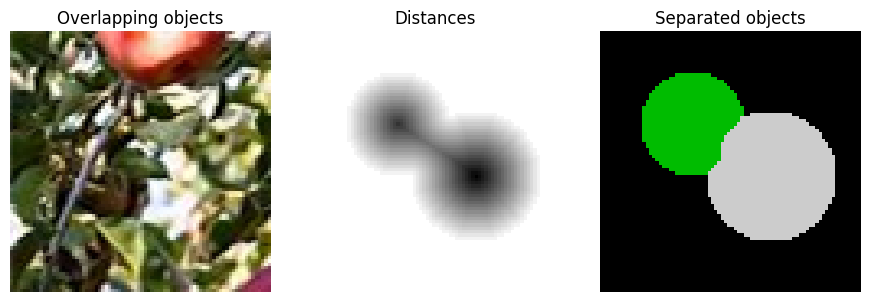

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=image)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

image = Image.open("../Attachment/Attachment 1/5.jpg")
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()